# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [1]:
#! pip install numpy
#!pip install gensim
#!pip uninstall numpy

In [2]:
#!pip install numpy==1.19.3

In [3]:
#!pip install --upgrade numpy
# !pip install --upgrade gensim
# !pip install spacy==3.2.0
# !pip install gensim==3.9.5

In [2]:
!pip install numpy==1.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 4.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nmslib 2.1.1 requires pybind11<2.6.2, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.22.0 which is incompatible.
tensorflow-text 2.8.1 requires tensorflow<2.9,>=2.8.0, but you have tensorflow 2.10.0 which is incompatible.
statsmodels 0.13.2 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
pycaret 2.3.10 requires gensim<4.0.0, but you have gensim 4.3.0 which is incompatible.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.10.0 which is incompatible.
pycaret 2.3.10 requires spacy<2.4.0, but y

In [1]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

from datetime import datetime
print(datetime.now())

/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


2023-02-14 12:26:47.028904


# 1: Functions for LDA and NMF

In [2]:
def get_tfidf_model(dataframe, text_column, min_df = 5, max_df=100000):
    stopwords = nltk.corpus.stopwords.words('english')
    #new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no","hm","wow"] "ok",
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','Mm','Oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords.extend(new_stopwords)
    min_df = 5
    max_df = 100000
    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()
    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

In [3]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

In [4]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    topic_id_text_lis = [] 
    for topic_idx, topic in enumerate(model.components_):
        topic_id =topic_idx
        topic_keyword =" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(topic_id,topic_keyword)
        new_id_keywords = str(topic_id)+':'+topic_keyword
        topic_id_text_lis.append(new_id_keywords)
    return topic_id_text_lis

In [5]:

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result



In [6]:
def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['label'].value_counts().index:
        ser = df_result.loc[df_result['label']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['label'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['label'].value_counts()))
    count = 0
    for i in df_result['label'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

In [7]:
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                ## check if word in vocabulary first!! Added by Sumithra
                if pair[0] in w2v_model.wv.index_to_key and pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                    if print_pairs:
                        print(pair[0], pair[1], w2v_model.wv.similarity(pair[0], pair[1]))
                else:
                    if print_pairs:
                        print('word pair not in vocabulary', pair[0], pair[1])
                    pair_scores.append( 0.0 )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

In [8]:
 class TokenGenerator:
        def __init__( self, documents, stopwords ):
            self.documents = documents
            self.stopwords = stopwords
            self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

        def __iter__( self ):
            #print("Building Word2Vec model ...")
            for doc in self.documents:
                tokens = []
                for tok in self.tokenizer.findall( doc ):
                    if tok.lower() in self.stopwords:
                        tokens.append( "<stopword>" )
                    elif len(tok) >= 2:
                        tokens.append( tok.lower() )
                yield tokens


In [9]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

## Read data

In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# read the data that we prepared for analysis
df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
print(df.shape)
print(df.columns)



(17953, 8)
Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response'],
      dtype='object')


In [22]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string
import numpy as np
import pandas as pd

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = stopwords.words('english')
    
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','Mm','Oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords_list.extend(new_stopwords)
    
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    # stemming
    ps  = PorterStemmer()
    word_list = [ps.stem(word) for word in word_list]  
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)   
    return sentence


In [17]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [12]:
df['sep_response']=df['response'].str.lower().apply(lambda x: word_tokenize(x))
porter_stemmer = PorterStemmer()
df['response_stem'] = df['sep_response'].apply(lambda x: [porter_stemmer.stem(y) for y in x])
df['response_stem'] = df['response_stem'].apply(lambda x: ' '.join(x))

In [23]:
# display(df['response_stem'].head())
df['new_response'] = df['response'].progress_apply(lambda x: clean_text(str(x)))

  0%|          | 0/17953 [00:00<?, ?it/s]

In [24]:
display(df['new_response'].head())

0                      
1                      
2                      
3              say like
4    someth said someth
Name: new_response, dtype: object

In [25]:
df['index'] = range(0,len (df))

## NMF model and the corresponding results

In [27]:
# df =df.dropna(subset='LIWC_response')
df['index'] = range(0,len (df))
# Compute coherence score 
import gensim
kmin, kmax = 10, 25
feature_names, document_tfidf = get_tfidf_model(df, 'new_response')
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    #print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF( n_components=k, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd') 
    W = model.fit_transform(document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','Mm','Oop']
# new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
# new_stopwords =  ["um", "ok", "oh", "okay", "mhm","ah","uh","hm","wow",'.','?','-','--',':','mm']
stopwords.extend(new_stopwords)
docgen = TokenGenerator(df['new_response'], stopwords)
# docgen = TokenGenerator(df['response'])
print(docgen)
w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence( w2v_model, term_rankings ) )
    #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) ) 
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
print(best_k)

12


0 realli - anyth - much - mind - noth - angri - excit - annoy - emot - express - want - never - problem - happi - understand
1 like - kind - stuff - thing - peopl - want - mean - would - school - got - said - anyth - someth - look - sort
2 think - anyth - actual - thing - stuff - might - situat - kind - worri - mani - go - rememb - need - head - pretti
3 know - actual - kind - mean - go - want - explain - peopl - dont - work - deal - guess - alreadi - chang - rememb
4 sometim - annoy - angri - depend - want - ask - tell - mean - guess - cri - shout - bit - might - brother - bore
5 feel - make - happi - bit - better - angri - good - emot - upset - sad - quit - stress - calm - anyth - way
6 someth - tri - time - thing - bit - calm - annoy - help - quit - happen - lot - stress - probabl - guess - make
7 well - want - kind - school - thing - usual - friend - test - end - either - see - got - teacher - happen - still
8 one - first - second - last - option - middl - thing - pick - mani - two

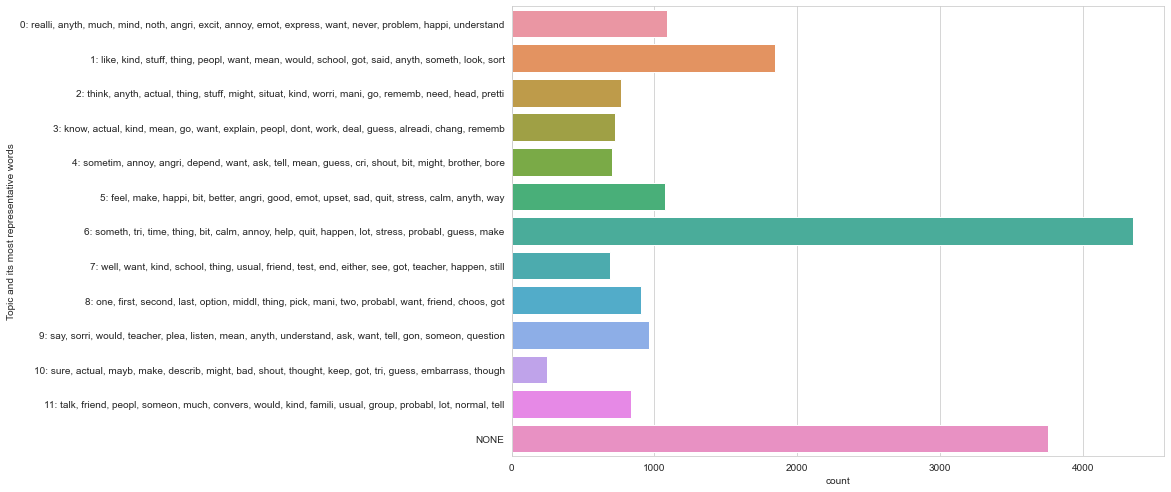

In [29]:
## let's see if the models produce something coherent with the best_k number
# no_topics = best_k
no_topics = best_k
## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 15
#lda = getLDAModel(no_topics, document_tfidf)
nmf, W, H = getNMFModel(no_topics, document_tfidf)
result1= display_topics(nmf, feature_names, no_top_words) 
#new_file.write(str(best_k)+','+str(result1)+'\n')
print('Representation of the main topic for each document')
tlist = get_topic_list(nmf,feature_names, no_top_words)
df_result = display_topic_representation(W,df,tlist)

In [30]:
df_result.head()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,sep_response,response_stem,...,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,Topic most represented,Topic and its most representative words
2367,2367,ASD.ADHD,Activity Two,986_25_06_2022,[00:11:48],No not really.,True,not,"[no, not, really, .]",no not realli .,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,"0: realli, anyth, much, mind, noth, angri, exc..."
2202,2202,ASD.ADHD,Activity Two,965_28_06_2022,[00:50:58],I'm not really popular.,True,not really,"[i, 'm, not, really, popular, .]",i 'm not realli popular .,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,"0: realli, anyth, much, mind, noth, angri, exc..."
10321,10321,ADHD,Activity Three,081_21_04_2022,[01:32:30],It just really made me angry because he kept ...,True,really made angry because he calling can't why...,"[it, just, really, made, me, angry, because, h...",it just realli made me angri becaus he kept ca...,...,0.0,0.000989,0.005295,0.0,0.0,0.018091,0.0,0.0,0,"0: realli, anyth, much, mind, noth, angri, exc..."
15404,15404,ASD,Activity Two,177_19_04_2022,[00:10:35],No not really that's it.,True,not really,"[no, not, really, that, 's, it, .]",no not realli that 's it .,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,"0: realli, anyth, much, mind, noth, angri, exc..."
10317,10317,ADHD,Activity Three,081_21_04_2022,[01:30:46],No not really.,True,not,"[no, not, really, .]",no not realli .,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,"0: realli, anyth, much, mind, noth, angri, exc..."


In [31]:
df_result.tail()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,sep_response,response_stem,...,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,Topic most represented,Topic and its most representative words
12990,12990,ASD,Activity Two,947_20_06_2022,[00:26:50],Yeah.,False,NaN,"[yeah, .]",yeah .,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
4376,4376,ASD.ADHD,Activity Two,Pilot13_03_03_2022,[00:29:51],Very very relieving.,False,NaN,"[very, very, relieving, .]",veri veri reliev .,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
4377,4377,ASD.ADHD,Activity Two,Pilot13_03_03_2022,[00:29:55],Yeah.,False,NaN,"[yeah, .]",yeah .,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
13005,13005,ASD,Activity Three,947_20_06_2022,[00:35:47],Yeah.,False,NaN,"[yeah, .]",yeah .,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
0,0,ASD.ADHD,Activity Three,974_16_06_2022,[00:00:14],Yeah.,False,NaN,"[yeah, .]",yeah .,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE


In [32]:
print(df_result.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response', 'sep_response', 'response_stem',
       'new_response', 'index', 'topic0', 'topic1', 'topic2', 'topic3',
       'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10',
       'topic11', 'Topic most represented',
       'Topic and its most representative words'],
      dtype='object')


In [33]:
print(df_result.shape)

(17953, 26)


In [34]:
new_result = df_result[df_result['Topic and its most representative words'] !='NONE']
print(new_result.shape)

(14201, 26)


In [35]:
new_df = new_result[['ids', 'diagnosis','section', 'pilot_number', 'inter_time', 'response','LIWC_response', 'new_response','Topic most represented', 'Topic and its most representative words']]

In [36]:
#!pip install xlwt
import xlwt
new_df.to_excel('All interviewees responses and the corresponding representative words_withoutNONE_updated.xlsx',index=False)